# Text classification using machine learning

Run this code __AFTER__ *preprocessing.ipynb*!

## 1. Start-up code: Import packages and get data

In [1]:
# UNCOMMENT TO INSTALL PACKAGES
#!pip install pandas numpy seaborn matplotlib scikit-learn

In [2]:
# system tools
import os
import re

# data wrangling
import pandas as pd
import numpy as np

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [3]:
# define path
path = os.path.join("..", "in", "balanced_dataset.csv")

In [4]:
# read csv
df = pd.read_csv(path)
# make sure ratings are parsed as strings and not integers
df['rating'] = df['rating'].astype(str)

In [5]:
# create a new column 'category_id' with encoded categories 
df['category_id'] = df['rating'].factorize()[0]
# remove duplicates
category_id_df = df[['rating', 'category_id']].drop_duplicates()
# create dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'rating']].values)

## Vectorisation

### TD-IDF

In [6]:
# vectorise the texts
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df= 5, # exclude tokens that occurred in less than 5 texts
                        ngram_range=(1, 2),
                        encoding = 'utf-16',
                        max_features = None)
# We transform each review into a vector
features = tfidf.fit_transform(df['review'].values.astype('str')).toarray()

# get labels
labels = df.category_id
print("Each of the %d reviews is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 85290 reviews is represented by 22969 features (TF-IDF score of unigrams and bigrams)


In [7]:
# find the 15 most correlated terms with each of the ratings
N = 15
out_file = "../out/correlated_terms.txt"    
    
with open(out_file, 'w') as f:
    f.write("MOST CORRELATED TERMS PER CATEGORY\n")
    for rating, category_id in sorted(category_to_id.items()):
        features_chi2 = chi2(features, labels == category_id)
        indices = np.argsort(features_chi2[0])
        feature_names = np.array(tfidf.get_feature_names_out())[indices]
        unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
        bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
        #print("n==> %s:" %(rating))
        #print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
        #print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
        f.write("n==> %s:\n" %(rating))
        f.write("  * Most Correlated Unigrams are: %s\n\n" %(', '.join(unigrams[-N:])))
        f.write("  * Most Correlated Bigrams are: %s\n\n\n" %(', '.join(bigrams[-N:])))

print("Correlated terms have been written to '%s'." % out_file)

Correlated terms have been written to '../out/correlated_terms.txt'.


## Finding the best classifier

In [8]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.25,
                                                    random_state = 42)

In [9]:
# list of models we want to test
models = [
    LinearSVC(),
    MultinomialNB(),
    ComplementNB(),
    LogisticRegression(random_state=42, max_iter = 85290),
]

In [10]:
# cross-validation of 3
CV = 3 # the number of subsets into which the dataset is divided during cross-validation
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [11]:
model_names = ["LinearSVC", "MultinomialNB", "ComplementNB", "LogisticRegression"]

In [12]:
entries = []
counter = 0
for model in models:
    title = model_names[counter]
    print(f"{title}...")
    counter += 1
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, accuracy))
    print(f"Complete!\n")
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy'])

LinearSVC...
Complete!

MultinomialNB...
Complete!

ComplementNB...
Complete!

LogisticRegression...
Complete!



In [13]:
cv_df.groupby(by = "model_name").mean()

,accuracy
model_name,
ComplementNB,0.465177
LinearSVC,0.447418
LogisticRegression,0.475730
MultinomialNB,0.477918


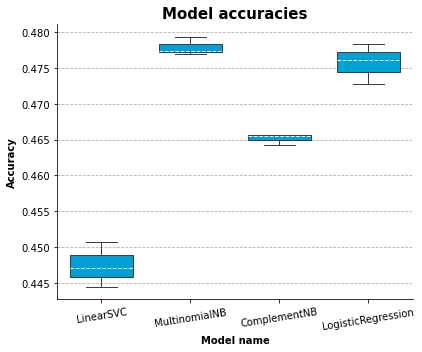

In [15]:
plt.rc('axes', axisbelow=True) # place gridlines below elements in plots

# Boxplot
fig, ax = plt.subplots(figsize=(6,5))

ax = sns.boxplot(x='model_name', y='accuracy', 
                 data=cv_df,
                 linewidth=1,
                 width=0.7,
                 fliersize=5,
                 boxprops={"facecolor": "#01a0d6"}, 
                 medianprops={"linewidth" : 1, "linestyle" : "--", "color" : "#edfbfe"})
plt.title("Model accuracies", weight = "bold", fontsize=15)
plt.ylabel("Accuracy", fontsize=10, weight="bold")
plt.xlabel("Model name", fontsize=10, weight="bold")
plt.grid(axis="y", linestyle='--')
plt.xticks(rotation=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()  # adjust layout to prevent labels from being cut off
plt.savefig('../out/model_accuracies.png', dpi=300, bbox_inches='tight') # save the figure
plt.show()

## Training and testing the classifier

In [2]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

NameError: name 'train_test_split' is not defined

In [17]:
# classification report
report = metrics.classification_report(y_test, y_pred, target_names= df['rating'].unique())

# write the classification report to a TXT file
with open('../out/classification_report.txt', 'w') as file:
    file.write(report)

# print the classification report
print('CLASSIFICATION METRICS\n')
print(report)

CLASSIFICATION METRICS

              precision    recall  f1-score   support

           1       0.51      0.59      0.55      4231
           2       0.38      0.40      0.39      4267
           3       0.41      0.35      0.38      4281
           4       0.51      0.35      0.41      4387
           5       0.57      0.72      0.64      4157

    accuracy                           0.48     21323
   macro avg       0.48      0.48      0.47     21323
weighted avg       0.48      0.48      0.47     21323



In [18]:
from  matplotlib.colors import LinearSegmentedColormap
c = ["#edfbfe", "#aee0f5","#6bcae8","#01a0d6","#1b91b8","#166c8c","#0d4960"]
v = [0,.15,.4,.5,0.6,.9,1.]
l = list(zip(v,c))
cmap=LinearSegmentedColormap.from_list('rg',l, N=256)

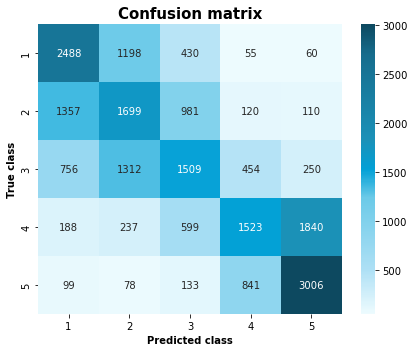

In [19]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, cmap = cmap, fmt='d',
            xticklabels=category_id_df.rating.values, 
            yticklabels=category_id_df.rating.values)
plt.ylabel('True class', fontsize = 10, weight = "bold")
plt.xlabel('Predicted class', fontsize = 10, weight = "bold")
plt.title("Confusion matrix", weight = "bold", fontsize=15)
plt.tight_layout()  # adjust layout to prevent labels from being cut off
plt.savefig('../out/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Prediction of new reviews from TrustPilot

In [1]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size=0.25,
                                                    random_state = 42)

NameError: name 'train_test_split' is not defined

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df= 5,
                        ngram_range=(1, 2), encoding = 'utf-16')
fitted_vectorizer = tfidf.fit(X_train.astype('str'))
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train.astype('str'))
model = MultinomialNB().fit(tfidf_vectorizer_vectors, y_train)

In [26]:
# This was a 2-star review
rev = """Jeg fik aldrig besked om at pakken kunne hentes.
Kontakt til Postnord er særdeles utilfredsstillende. Kan ikke kontaktes på telefon. Ved chat oplevede jeg to gange ca. 75 min ventetid, og de fik ikke løst problemet.
Jeg endte med at kontakte Shell tanken for at høre om de måtte have pakken liggende. Og det havde de, den var bare ikke blevet registreret. Jeg hentede derefter pakken.
Mvh Claus"""

print(f"The model predicted this 2-star review to be a {model.predict(fitted_vectorizer.transform([rev]))}-star review")

The model predicted this 2-star review to be a ['1']-star review


In [27]:
# This was a 5-star review
rev = """Jeg fik en sms om at min pakke var afleveret i postkassen, men der var ingen pakke der. Prøvede så at ringe til post nord, det er bare så ringe at komme igennem til jer. Så tog jeg fat i vores søde post dame, og så fiskede hun lige sagen og jeg fik pakken et par dage efter. 💪"""

print(f"The model predicted this 5-star review to be {model.predict(fitted_vectorizer.transform([rev]))} stars")

The model predicted this 5-star review to be ['1'] stars


In [28]:
# This was a 5-star review
rev = """JEG FANDT MIN PAKKE I MIT SKUR DET VAR DEJLIGT SÅ SKULLE JEG IKKE HENTE DEN ET ANDET STED DET VAR JEG GLAD FOR MEN HAR IKKE PAKKET DEN UD ENDNU DA JEG SKAL HAVE HJÆLP TIL AT FÅ DEN TILSLUTTET TAK MED VENLIG HILSEN SONJA KNUDSEN ÅBYBRO."""

print(f"The model predicted this 5-star review to be {model.predict(fitted_vectorizer.transform([rev]))} stars")

The model predicted this 5-star review to be ['4'] stars


In [29]:
# This was a 3-star review
rev = """Altid hurtig, men jeg tror ikke buddene forstår Modtager Flex. Jeg er tilmeldt, men sidst ringede buddet fordi jeg ikke var hjemme (heldigvis, så jeg kunne sige at jeg var tilmeldt det og at han kunne sætte pakken) 
Næste gang tog buddet et billede af pakken ved døren, men har så taget den med igen, hvilket bare gav forvirring for mig om hvorvidt den var blevet sat der eller ej.

Af en eller anden grund bliver pakkerne også oftest lagt i en pakkeshop over 3 km væk, selvom der er mere end en pakkeshop tættere på. Det er virkelig irriterende, især når pakken i første omgang bare skulle have været sat ved døren"""

print(f"The model predicted this 3-star review to be {model.predict(fitted_vectorizer.transform([rev]))} stars")

The model predicted this 3-star review to be ['2'] stars
